# Introduction
#### This Notebook contains a solution attempt to the SFL Scientific technical problem. 

I attempted two different approaches to extracting the data from the midi files. The one simply built a tick-by-tick map of which notes are on or off for each tick of the entire track. This was then reduced and flattend as an numpy array for consumption by various models. The other approach was completely different, extracting meaningful musical content such as notes, chords, key and time signature, chord complexity, and various other measures of the tracks. 

For each manner of data pre-processing, I attempted to first operate within the realm of the problem and supplied data and train unsupervised outlier detectors of various kinds on the content of the folder PS1 or if model design required, the combined contents of each PS1 and PS2. No model I attempted (mostly out of the box from sklearn) was able to reliably identify the outlier files without false positive rates near 50%. 

Subsequently, I used the MusicNet dataset to extend the sample to known works by composers other than Bach, Brahms, Beethoven, and Schubert. Very quickly, a naive bayes model trained on this extended dataset was able to correctly and exactly identified the 3 tracks in PS2 attributable to Mozart. However, by pattern matching on the content of the files, I was able to determine that I had added the problem's outliers to the training set, breaking the nature of the problem. I migrated the outliers out of the training set to restore some difficulty to the space. In the event that a larger dataset was not available online, I may have constructed one by downloading files from MuseScore.com and converting them with MuseScore manually, or even by constructing my own by exporting directly from my keyboard. 

Ultimately, I found that by double-processing the inputs from PS2, a logistic regression classifier was able to pick out the outliers plus 3-5 false positives. By tuning the probability threshold and repeating the process, I was able to reliably produce a list of 4 labeled outliers, 3 of which are correct, and one is an outlier. This tuning probably constitutes an overfit for the model in general use, and would not serve particularly well on additional data, even from MusicNet. 

Investigation of the data showed that these four tracks were exceptionally slow or fast tempo compared to the others. So it is likely that the model is picking up on some element of tempo as a principal component of the datas defining characteristics. Given that Mozart composed many up-tempo pieces, we can conclude that this model's success is mostly an accident of this particular selection of data. This stands as a significant limitation of the solution.

In [1]:
# Copyright Ian Hogan - 2022

# Imports
from mido import MidiFile
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB, CategoricalNB    
from sklearn.cluster import DBSCAN 
import math

In [2]:
# Class declarations
class Note():
    """ For the purposes of midi, a note is a pitch with a start and stop time. 
    instrument could be added later, if it adds value. """
    def __init__(self, pitch, start, stop):
        self.pitch = pitch
        self.start = start
        self.stop = stop
    def duration(self):
        return self.stop - self.start

class Chord():
    """While it's intuitively clear what a chord is, it's not actually that obvious how to construct them from a midi
    I'll see what I can do.
    """
    def __init__(self, notes):
        self.notes = notes
    def complexity(self): 
        return [
            # total number of notes is a measure of chord complexity
            len(self.notes), 
            # net dissonance internal to the chord is a measure of complexity. 
            chord_dissonance(self),
        ]


In [3]:
# Some useful dictionaries
#The outputs for a relative pitch difference are the denominators 
# of the relative frequencies in just intonation. This is entirely my own idea. 
dissonance_dict = {
    0: 1, # tonic
    1: 15, # flat 2
    2: 8, # second
    3: 5, # min third
    4: 4, # maj thirds
    5: 3, # perfect fourth
    6: 50, # tritone
    7: 2, # perfect fifth
    8: 5, # sharp 5
    9: 3, # sixth
    10: 4, # maj seventh
    11: 8, # seventh
}

key_dict = {
    'A': 0,
    'Bb': 1,
    'B': 2,
    'C': 3,
    'Db': 4,
    'D': 5,
    'Eb': 6,
    'E': 7,
    'F': 8,
    'Gb': 9,
    'G': 10,
    'Ab': 11,
    'Am': 12,
    'Bbm': 13,
    'Bm': 14,
    'Cm': 15,
    'Dbm': 16,
    'Dm': 17,
    'Ebm': 18,
    'Em': 19,
    'Fm': 20,
    'Gbm': 21,
    'Gm': 22,
    'Abm': 23,
}

In [4]:
# Helper method definitions
from outlier_pipeline import *


<midi file 'composerMidis/musicnet_midis/Beethoven/2318_bh38m1.mid' type 1, 6 tracks, 15274 messages>
<midi track 'Trio für Klarinette, Cello und Klavier Op.38, Allegro con brio' 84 messages>


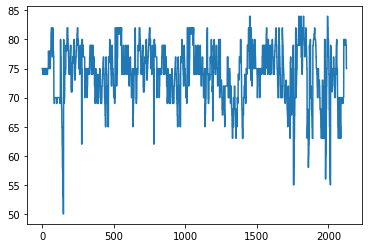

In [13]:
optional_visualization()

In [15]:
# Optional - this code used the PS1 data only and attempted to manually extract meaningful features. 
test_midi_reduction_techniques_unsupervised()

Loading training and test data.
Performing feature extraction from midi data.
One class svm
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
0.06402123326764841_adj.mid
Isolation Forest
Model is fit, predicting on original data. 
[ 1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1

In [ ]:
# Also optional
test_extracted_data_supervised()   

Loading training and test data.
Using supervised Logistic Regression.
0.37667550741095396 0.002716920481628_adj.mid
0.4326582165099619 0.22047111832936942_adj.mid
0.4192571291753057 0.26551079719260606_adj.mid
0.3782654751765977 0.3334293069825759_adj.mid
0.3249888655222901 0.549470161204349_adj.mid
0.410219434136671 0.981087291054314_adj.mid
Visualizing once and twice processed data from the test set, filename: 0.002716920481628_adj.mid


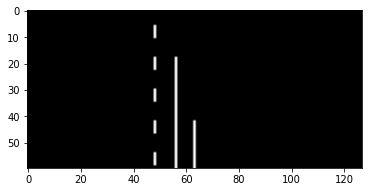

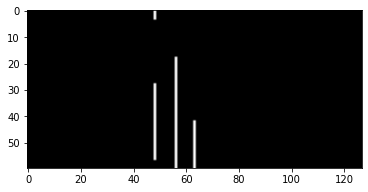

Visualizing once and twice processed data from the test set, filename: 0.033313986422223163_adj.mid


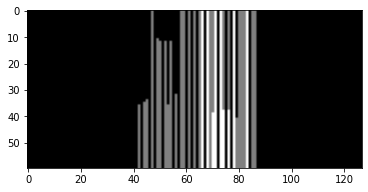

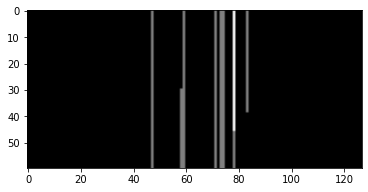

Visualizing once and twice processed data from the test set, filename: 0.047574444458241216_adj.mid


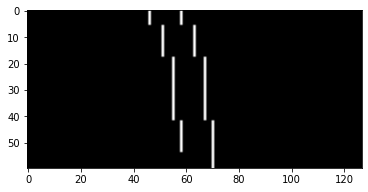

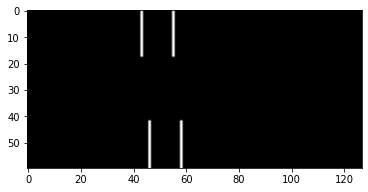

Visualizing once and twice processed data from the test set, filename: 0.06402123326764841_adj.mid


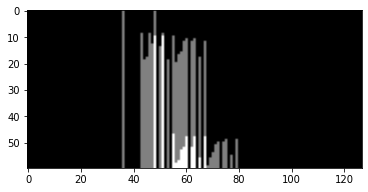

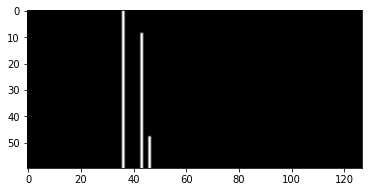

Visualizing once and twice processed data from the test set, filename: 0.07186746659481313_adj.mid


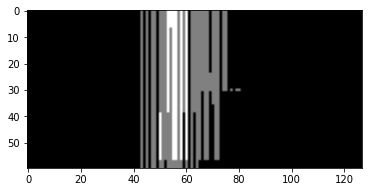

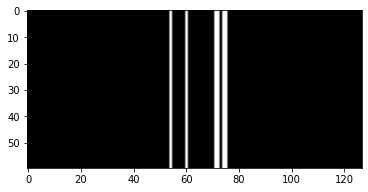

Visualizing once and twice processed data from the test set, filename: 0.09167358800381353_adj.mid


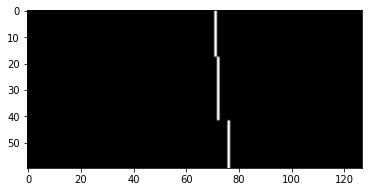

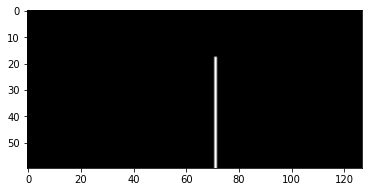

Visualizing once and twice processed data from the test set, filename: 0.10222964826466285_adj.mid


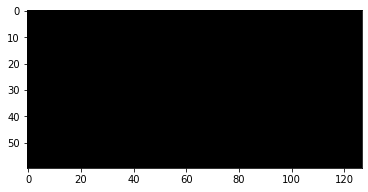

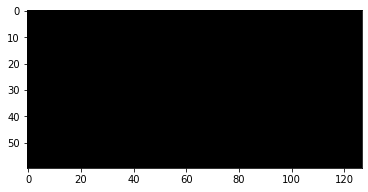

Visualizing once and twice processed data from the test set, filename: 0.10250888365879718_adj.mid


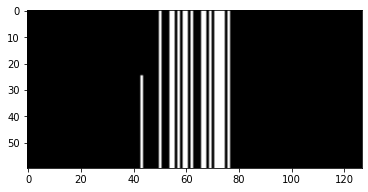

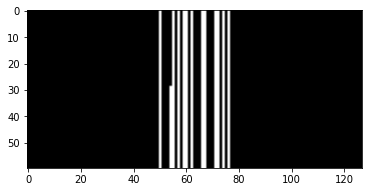

Visualizing once and twice processed data from the test set, filename: 0.10630249969742178_adj.mid


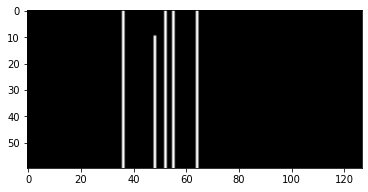

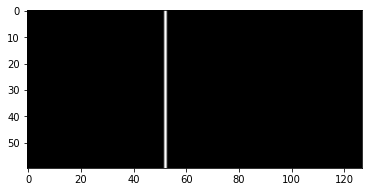

Visualizing once and twice processed data from the test set, filename: 0.1755252422917658_adj.mid


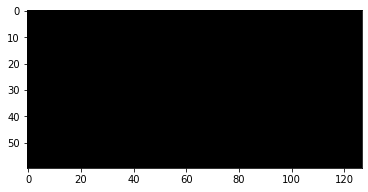

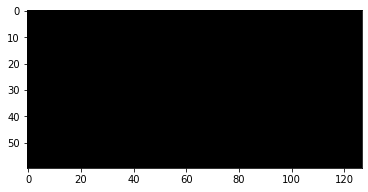

Visualizing once and twice processed data from the test set, filename: 0.1960551158929671_adj.mid


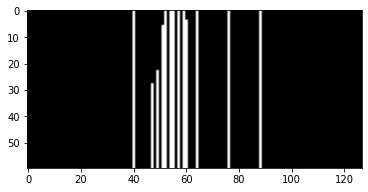

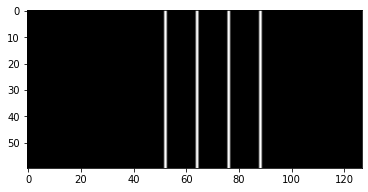

Visualizing once and twice processed data from the test set, filename: 0.21198476749665085_adj.mid


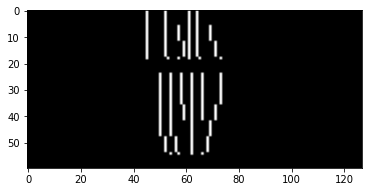

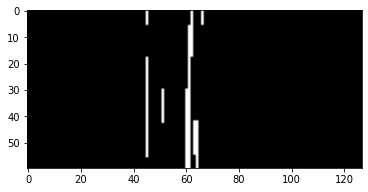

Visualizing once and twice processed data from the test set, filename: 0.21901852969811753_adj.mid


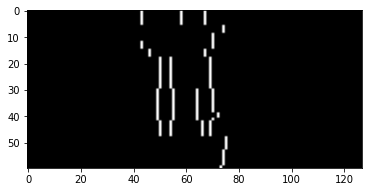

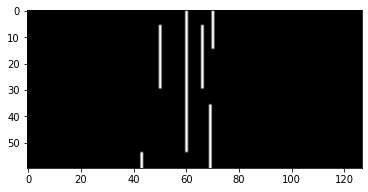

Visualizing once and twice processed data from the test set, filename: 0.22047111832936942_adj.mid


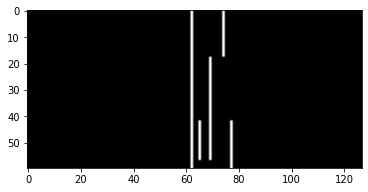

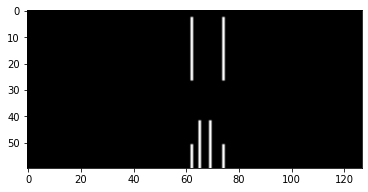

Visualizing once and twice processed data from the test set, filename: 0.23120017256495873_adj.mid


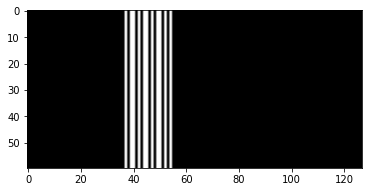

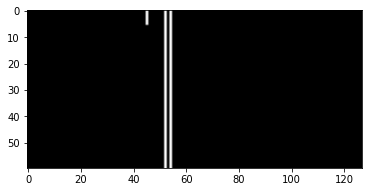

Visualizing once and twice processed data from the test set, filename: 0.26551079719260606_adj.mid


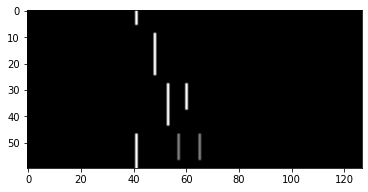

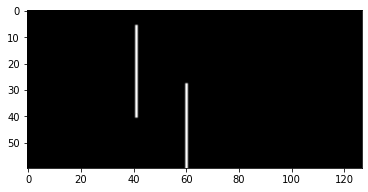

Visualizing once and twice processed data from the test set, filename: 0.30993012400290976_adj.mid


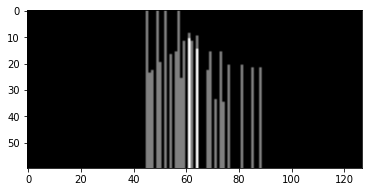

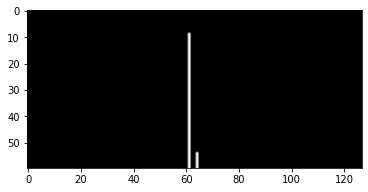

Visualizing once and twice processed data from the test set, filename: 0.3264565808984162_adj.mid


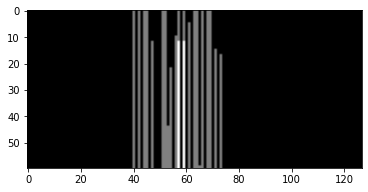

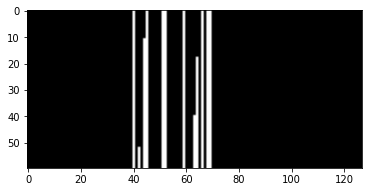

Visualizing once and twice processed data from the test set, filename: 0.3334293069825759_adj.mid


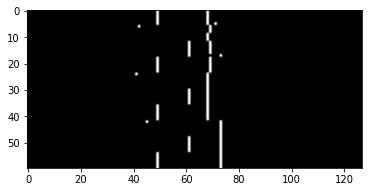

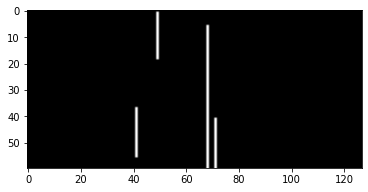

Visualizing once and twice processed data from the test set, filename: 0.33695573887576447_adj.mid


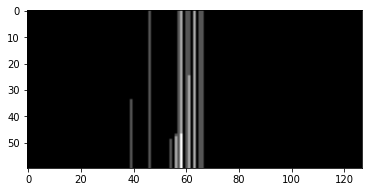

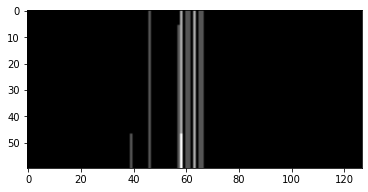

Visualizing once and twice processed data from the test set, filename: 0.337517805339117_adj.mid


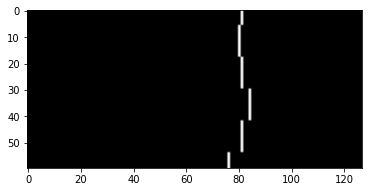

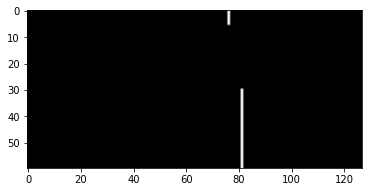

Visualizing once and twice processed data from the test set, filename: 0.3559970176888735_adj.mid


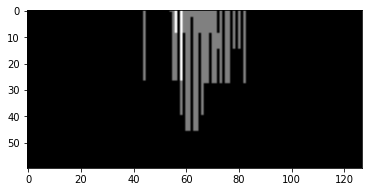

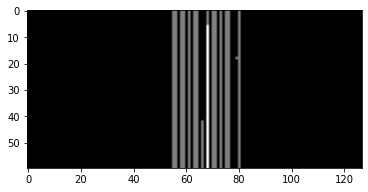

Visualizing once and twice processed data from the test set, filename: 0.3620067189216978_adj.mid


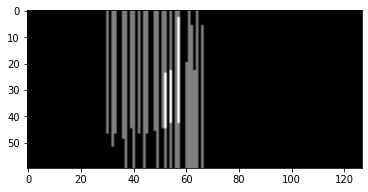

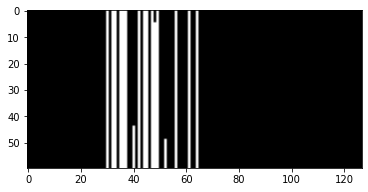

Visualizing once and twice processed data from the test set, filename: 0.36321860283443286_adj.mid


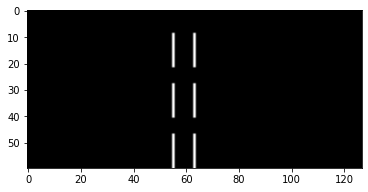

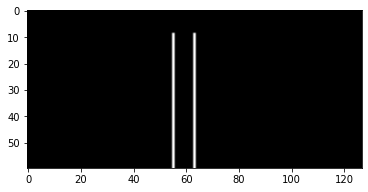

Visualizing once and twice processed data from the test set, filename: 0.48367685897240176_adj.mid


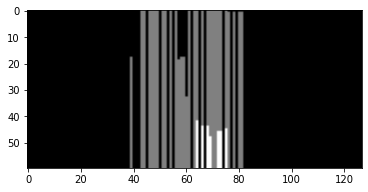

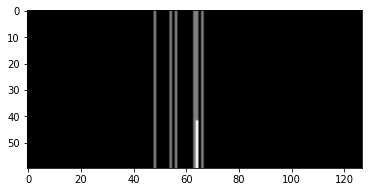

Visualizing once and twice processed data from the test set, filename: 0.539512676743813_adj.mid


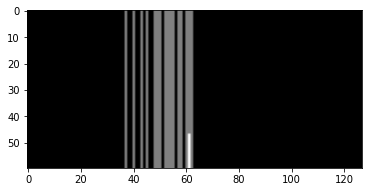

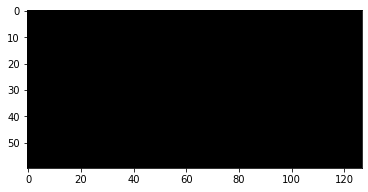

Visualizing once and twice processed data from the test set, filename: 0.549470161204349_adj.mid


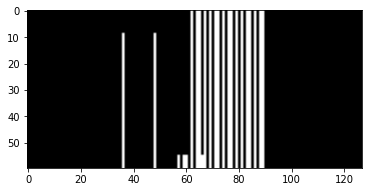

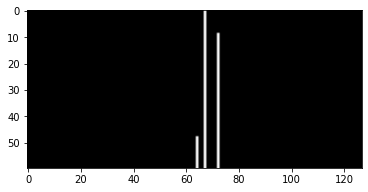

Visualizing once and twice processed data from the test set, filename: 0.5807329043589801_adj.mid


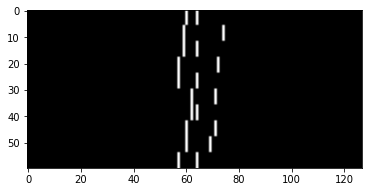

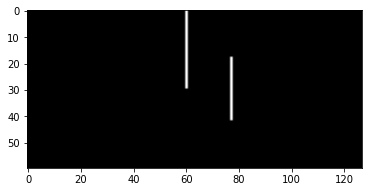

Visualizing once and twice processed data from the test set, filename: 0.647959423719129_adj.mid


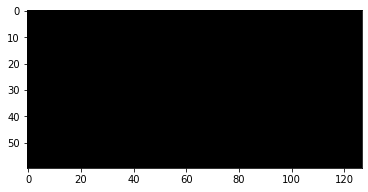

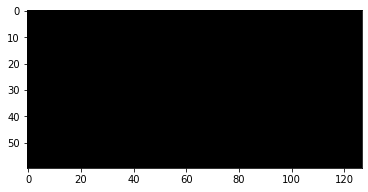

Visualizing once and twice processed data from the test set, filename: 0.7491289879531658_adj.mid


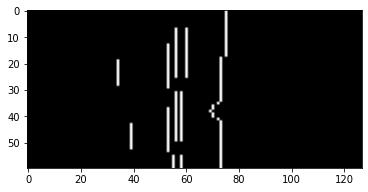

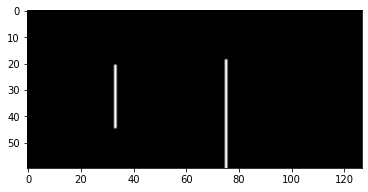

Visualizing once and twice processed data from the test set, filename: 0.8014751784512073_adj.mid


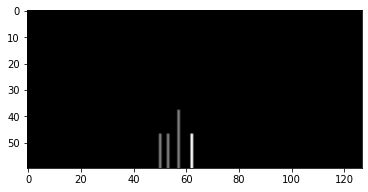

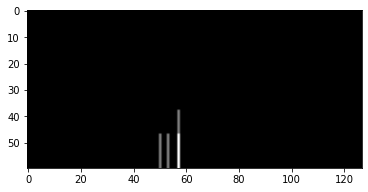

Visualizing once and twice processed data from the test set, filename: 0.905499891236923_adj.mid


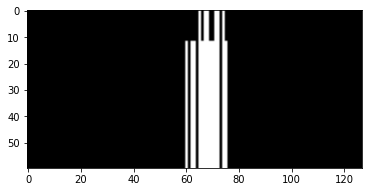

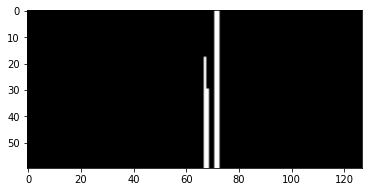

Visualizing once and twice processed data from the test set, filename: 0.9353908329958764_adj.mid


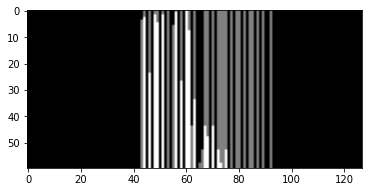

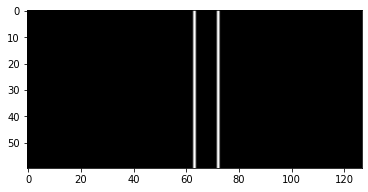

Visualizing once and twice processed data from the test set, filename: 0.9511403301279795_adj.mid


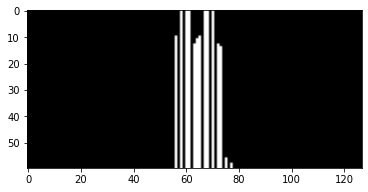

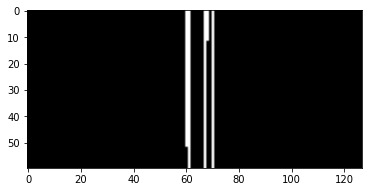

Visualizing once and twice processed data from the test set, filename: 0.981087291054314_adj.mid


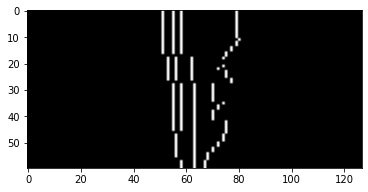

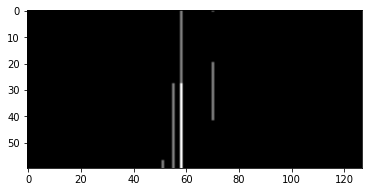

In [11]:
# This is the model that ultimately worked reasonably well. 
print("Loading training and test data.")
midis, non_midis = load_training_data()

# Sample vizualization - optional. 
#optional_visualization()    

# load into numpy because sklearn likes numpy
data = []
for mid in midis:
    data.append(np.array(reduce_midi_to_np_array(mid)))

for mid in non_midis:
    data.append(np.array(reduce_midi_to_np_array(mid)))#, mid[1]])

# Create a label set, 1 up to 184, 0 after. 
y_train = np.zeros(len(data))
y_train[:184] = 1

test_data = []
test_mids = load_test_data()

for mid in test_mids:
    test_data.append(np.array(reduce_midi_to_np_array(mid[0])))#, mid[1]])


print("Using supervised Logistic Regression.")

gnb = LogisticRegression(solver='liblinear', max_iter=250, penalty='l1')
y_pred = gnb.fit(data, y_train)
# print(gnb.predict(data))
# print(gnb.predict(test_data))

# When the mids in this set were processed down before, they were altered. Processing them down again
# somehow allows the model to flag 7 outliers, 3 of which are the correct ones. 
# I'm committing this because, hey, it kinda worked. 

# Thinking about how processing twice would work, I think the start and stop times of notes would be doubled. 
# which should perturb the model on ALL of the inputs, but somehow this allows it to catch the Mozart pieces... 
# Upon listening to the three outlier Mozart pieces, I can tell two of them are quite slow, so slowing them down much more
# could be what is tripping off the detector. This could be a valid preprocessor. Something about length of notes
# may be viable discriminator between composers within this particular problem space. 
test_two = []
for mid in test_mids:
    temp = np.array(reduce_midi_to_np_array(mid[0]))
    test_two.append([temp, mid[1]])
    pred = gnb.predict_proba([temp])
    # It appears that tuning the the probability down a little improves accuracy with minimal reduction in recall. 
    if pred[0][1] < 0.44:
        print(str(pred[0][1]) + " " + mid[1])

        # This appears to get all three, plus one or two false positive errata. 
#print(gnb.predict(test_two))

# Data visualization time. test_mids and test_two are the same length, so we can pairwise compare them. 
for i in range(len(test_two)):
    orig_two_d_array = np.reshape(test_data[i], (int(MAX_TICKS/10), 127))
    warp_two_d_array = np.reshape(test_two[i][0], (int(MAX_TICKS/10), 127))

    # too much black-space, need to trim to the reasonable region. 
    orig_reduced = orig_two_d_array[:10000][30:90]
    warp_reduced = warp_two_d_array[:10000][30:90]
    
    print("Visualizing once and twice processed data from the test set, filename: " + test_two[i][1])
    plt.imshow(orig_reduced, cmap='gray')
    plt.show()
    plt.imshow(warp_reduced, cmap='gray')
    plt.show()
    plt.close()
    

In [30]:
# To stabilize the logistic regression prediction somewhat, we can simply run it 100 times and determine a confidence. 
# Caution, this is fairly slow, but produces 4 outliers with confidence of at least 80%, and 3 of them are correct. 
print("Executing 100 rounds of train and label.")
candidates = []
for i in range(100):
    gnb = LogisticRegression(solver='liblinear', max_iter=250, penalty='l1')
    gnb.fit(data, y_train)
    for temp in test_two:
        pred = gnb.predict_proba([temp[0]])
        if pred[0][1] < 0.44:
            candidate_already_found = False
            for candidate in candidates:
                if temp[1] == candidate[0]:
                    candidate[1] += 1
                    candidate_already_found = True
                    break
            if not candidate_already_found:
                candidates.append([temp[1], 1])
            #print(str(pred[0][1]) + " " + temp[1])

print(candidates)

Executing 100 rounds of train and label.
[['0.002716920481628_adj.mid', 97], ['0.22047111832936942_adj.mid', 91], ['0.549470161204349_adj.mid', 99], ['0.5807329043589801_adj.mid', 21], ['0.981087291054314_adj.mid', 71], ['0.3334293069825759_adj.mid', 49], ['0.26551079719260606_adj.mid', 14], ['0.1960551158929671_adj.mid', 1]]
